# Test on Controllability and Robustness on Name Pair Task; Prediction on Last Name only; Train w/o Counterfactual

**input seq**: [SC] first_name_ctx has last name_ctx last_name [SEP] [EC] first_name 

**target seq**: has last name last_name [EOS]

- Training and Validation: first_name_ctx == first_name, last_name_ctx == last_name1  

- Counterfactual Testing: first_name_ctx == first_name, last_name_ctx != last_name 

- Counterfactual Irrelevant Testing: first_name_ctx != first_name, last_name_ctx != last_name 

- Counterfactual Irrelevant First Name Change Only Testing: first_name_ctx != first_name, last_name_ctx == last_name 

- Empty Context Testing: input  [SEP] first_name has last name, target last_name

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [2]:
import torch
import torchtext
from lightning.pytorch.loggers.wandb import WandbLogger
import torchmetrics

import numpy as np
import wandb
import torchinfo
from contextlib import nullcontext
from  tqdm import tqdm, trange
import argparse


import sys; sys.path += ['..']
from language_models import TransformerLM, configure_optimizers


## Config

In [3]:
args = argparse.Namespace(
    batch_size=32, n_epochs=100, log_on_step=True,
    wandb_project="controllability-robustness-test", run_name='hello', 
    n_layers=1, n_heads=4, d_model=128, dff=128*4)

In [4]:
# region some configuration
device = 'cuada'
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
# dtype = 'float32'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
# wandb logging
wandb_log = False
wandb_project = args.wandb_project
# endregion


## Data

In [5]:
# get data and vocab for the first 200 samples
data_path = '../name_pairs_dataset/full-sentences.txt'
with open(data_path) as f:
    full_data = f.read().splitlines()[:250]
    data = full_data[:200]
    data_val = full_data[200:250]
    last_names = [x.split(' ')[-1] for x in full_data]

with open('../name_pairs_dataset/first-names.txt') as f:
    first_names = f.read().splitlines()[:250]


# create vocab map
vocab = first_names + last_names
vocab = [x.lower() for x in vocab]
vocab += ['has', 'last', 'name', '[UNK]', '[sep]', '[sc]', '[ec]','[eos]']
vocab = list(set(vocab))
vocab_map = {vocab: i for i, vocab in enumerate(vocab)}
vocab_size = len(vocab)
print('vocab size: ', vocab_size) # vocab size is very large; especially for a task this simple

first_names = first_names[:200]
last_names = last_names[:200]
# keep the same first name in ctx, sample different last names
test_data_counterfactual = [f'{" ".join(sentence.split(" ")[:-1])} {last_names[np.random.randint(len(last_names))]}' for sentence in data]
test_data_counterfactual = [f'[SC] {sentence} [SEP] [EC] {sentence} [EOS]' for sentence in test_data_counterfactual]

# sample different first and last names in ctx
test_data_counterfactual_irrelevant = [f'{first_names[np.random.randint(len(first_names))]} {" ".join(sentence.split(" ")[1:])}' for sentence in data]
test_data_counterfactual_irrelevant = [f'{" ".join(sentence.split(" ")[:-1])} {last_names[np.random.randint(len(last_names))]}' for sentence in test_data_counterfactual_irrelevant]
test_data_counterfactual_irrelevant = [f'[SC] {test_data_counterfactual_irrelevant[i]} [SEP] [EC] {data[i]} [EOS]' for i in range(len(data))]

test_data_counterfactual_irrelevant_first_name_change = [f'{first_names[np.random.randint(len(first_names))]} {" ".join(sentence.split(" ")[1:])}' for sentence in data]
test_data_counterfactual_irrelevant_first_name_change = [f'[SC] {test_data_counterfactual_irrelevant_first_name_change[i]} [SEP] [EC] {data[i]} [EOS]' for i in range(len(data))]
print(test_data_counterfactual_irrelevant[:5])
print(test_data_counterfactual[:5])
print(test_data_counterfactual_irrelevant_first_name_change[:5])
# modify original sentences to include [SEP] token
data = [f'[SC] {sentence} [SEP] [EC] {sentence} [EOS]' for sentence in data]
data_val = [f'[SC] {sentence} [SEP] [EC] {sentence} [EOS]' for sentence in data_val]
print("data_val: ", data_val[:5])
# pick the last 1/2 of counterfactuals and add them to the training data
#data += test_data_counterfactual[100:]


tokenized_data = [sentence.strip().lower().split(' ') for sentence in tqdm(data)]
tokenized_data_val = [sentence.strip().lower().split(' ') for sentence in tqdm(data_val)]
test_tokenized_data_counterfactual = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual)]
test_tokenized_data_counterfactual_irrelevant = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual_irrelevant)]
test_tokenized_data_counterfactual_irrelevant_first_name_change = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual_irrelevant_first_name_change)]

integer_ids = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data)]
integer_ids = torch.tensor(np.array(integer_ids))
integer_ids_val = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data_val)]
integer_ids_val = torch.tensor(np.array(integer_ids_val))
integer_test_ids_counterfactual = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual)]
integer_test_ids_counterfactual = torch.tensor(np.array(integer_test_ids_counterfactual))
integer_test_ids_counterfactul_irrelevant = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual_irrelevant)]
integer_test_ids_counterfactul_irrelevant = torch.tensor(np.array(integer_test_ids_counterfactul_irrelevant))
integer_test_ids_counterfactual_irrelevant_first_name_change = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual_irrelevant_first_name_change)]
integer_test_ids_counterfactual_irrelevant_first_name_change = torch.tensor(np.array(integer_test_ids_counterfactual_irrelevant_first_name_change))

# create dataset and dataloader
x = integer_ids[:, :-1]
y = integer_ids[:, -5:]
x_out = integer_ids[:, 1:]
x_val = integer_ids_val[:, :-1]
y_val = integer_ids_val[:, -5:]
x_out_val = integer_ids_val[:, 1:]
x_test_counterfactual = integer_test_ids_counterfactual[:, :-1]
y_test_counterfactual = integer_test_ids_counterfactual[:, -5:]
x_out_test_counterfactual = integer_test_ids_counterfactual[:, 1:]
x_test_counterfactual_irrelevant = integer_test_ids_counterfactul_irrelevant[:, :-1]
y_test_counterfactual_irrelevant = integer_test_ids_counterfactul_irrelevant[:, -5:]
x_out_test_counterfactual_irrelevant = integer_test_ids_counterfactul_irrelevant[:, 1:]
x_test_counterfactual_irrelevant_first_name_change = integer_test_ids_counterfactual_irrelevant_first_name_change[:, :-1]
y_test_counterfactual_irrelevant_first_name_change = integer_test_ids_counterfactual_irrelevant_first_name_change[:, -5:]
x_out_test_counterfactual_irrelevant_first_name_change = integer_test_ids_counterfactual_irrelevant_first_name_change[:, 1:]

x_train, y_train, x_val, y_val, x_train_test, y_train_test, x_val_test, y_val_test = x, x_out, x_val, x_out_val, x[:,:-4], y, x_val[:,:-4], y_val
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
train_dataset_test = torch.utils.data.TensorDataset(x_train_test, y_train_test)
val_dataset_test = torch.utils.data.TensorDataset(x_val_test, y_val_test)

test_dataset_counterfactual = torch.utils.data.TensorDataset(x_test_counterfactual[:,:-4], y_test_counterfactual)
test_dataset_counterfactual_irrelevant = torch.utils.data.TensorDataset(x_test_counterfactual_irrelevant[:,:-4], y_test_counterfactual_irrelevant)
test_dataset_counterfactual_irrelevant_first_name_change = torch.utils.data.TensorDataset(x_test_counterfactual_irrelevant_first_name_change[:,:-4], y_test_counterfactual_irrelevant_first_name_change)

# take first 100 samples for testing
test_dataset_counterfactual = torch.utils.data.TensorDataset(*test_dataset_counterfactual[:100])
test_dataset_counterfactual_irrelevant = torch.utils.data.TensorDataset(*test_dataset_counterfactual_irrelevant[:100])
test_dataset_counterfactual_irrelevant_first_name_change = torch.utils.data.TensorDataset(*test_dataset_counterfactual_irrelevant_first_name_change[:100])

# dataloader
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
print("Number of batches: ", len(train_dl))
train_dl_test = torch.utils.data.DataLoader(train_dataset_test, batch_size=args.batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
val_dl_test = torch.utils.data.DataLoader(val_dataset_test, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual = torch.utils.data.DataLoader(test_dataset_counterfactual, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual_irrelevant = torch.utils.data.DataLoader(test_dataset_counterfactual_irrelevant, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual_irrelevant_first_name_change = torch.utils.data.DataLoader(test_dataset_counterfactual_irrelevant_first_name_change, batch_size=args.batch_size, shuffle=False)
seq_len = x.shape[1]
output_seq_len = y.shape[1]
print(len(test_dl_counterfactual), len(test_dl_counterfactual_irrelevant), len(test_dl_counterfactual_irrelevant_first_name_change))
for x, y in val_dl:
    print(x.shape, y.shape)
    break
    

vocab size:  507
['[SC] Aliza has last name WESTAD [SEP] [EC] Aaren has last name DURLAND [EOS]', '[SC] Agace has last name GERMAINE [SEP] [EC] Aarika has last name ROBITAILLE [EOS]', '[SC] Alys has last name HOLABAUGH [SEP] [EC] Abagael has last name SJOGREN [EOS]', '[SC] Agnese has last name SCHOPPE [SEP] [EC] Abagail has last name MENGSTEAB [EOS]', '[SC] Alyssa has last name BRICKETT [SEP] [EC] Abbe has last name OEHLENSCHLAGE [EOS]']
['[SC] Aaren has last name DHONDT [SEP] [EC] Aaren has last name DHONDT [EOS]', '[SC] Aarika has last name GUZI [SEP] [EC] Aarika has last name GUZI [EOS]', '[SC] Abagael has last name AHMADI [SEP] [EC] Abagael has last name AHMADI [EOS]', '[SC] Abagail has last name YOKUM [SEP] [EC] Abagail has last name YOKUM [EOS]', '[SC] Abbe has last name KOJIMA [SEP] [EC] Abbe has last name KOJIMA [EOS]']
['[SC] Adelice has last name DURLAND [SEP] [EC] Aaren has last name DURLAND [EOS]', '[SC] Aliza has last name ROBITAILLE [SEP] [EC] Aarika has last name ROBITAI

100%|██████████| 200/200 [00:00<00:00, 34916.16it/s]

Number of batches:  7
4 4 4
torch.Size([32, 13]) torch.Size([32, 13])


## Model

In [6]:
import lightning as L
import matplotlib.pyplot as plt

class LitLanguageModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.mismatched_sequences = []
        self.all_seq_acc = []
        self.all_per_pos_acc = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)
        self.log('train_loss', loss, prog_bar=True, logger=True, on_step=args.log_on_step, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)
        

        perplexity = torchmetrics.functional.text.perplexity(logits, y)
        self.log(f"val_loss", loss, prog_bar=True, logger=True, add_dataloader_idx=False)
        self.log(f'val_perplexity', perplexity, prog_bar=True, logger=True, add_dataloader_idx=False)

    def test_step(self, batch, batch_idx):

        x, y = batch
        # Generate predictions using the generate function, return the entire sequence
        predicted_idx = self.model.generate(x, max_new_tokens=y.size(1), top_k=1)
        generated_seq = predicted_idx[:, x.size(1):]
    
        
        # Calculate per position accuracy
        per_pos_acc = self.per_position_accuracy(generated_seq, y)  
        
        # Calculate whole sequence accuracy
        seq_acc = self.sequence_accuracy(generated_seq, y)
        
        # Store metrics for later averaging
        self.all_seq_acc.append(seq_acc)
        self.all_per_pos_acc.append(per_pos_acc)
        
        self.capture_mismatches(generated_seq,y, x)
        
    def sequence_accuracy(self, preds, targets):
        # Check if entire sequences match
        correct = torch.all(preds == targets, dim=1)
        accuracy = torch.mean(correct.float())
        return accuracy
    
    def per_position_accuracy(self, preds, targets):
        correct = preds == targets
        per_position_acc = correct.float().mean(dim=0)
        return per_position_acc
    
    def capture_mismatches(self, preds, targets, inputs, max_examples=1000):
        """
        Store examples of sequences where the predictions do not match the targets.
        
        Args:
            preds (torch.Tensor): The model's predicted sequences.
            targets (torch.Tensor): The actual sequences.
            inputs (torch.Tensor): The input sequences to the model.
            max_examples (int): Maximum number of mismatched sequences to store.
        """
        # Convert predictions to class indices
        mismatches = preds != targets
        
        # Iterate over the batch to find mismatches
        for i in range(mismatches.size(0)):
            if torch.any(mismatches[i]) and len(self.mismatched_sequences) < max_examples:
                mismatch_data = {
                    'input': inputs[i].cpu().numpy(),
                    'predicted': preds[i].cpu().numpy(),
                    'target': targets[i].cpu().numpy()
                }
                self.mismatched_sequences.append(mismatch_data)
                
    def on_test_epoch_end(self):
        # Calculate overall metrics from all batches
        if self.all_seq_acc and self.all_per_pos_acc:

            overall_seq_acc = torch.mean(torch.stack(self.all_seq_acc))
            overall_per_pos_acc = torch.mean(torch.stack(self.all_per_pos_acc), dim=0)
            # Log overall metrics
            self.log('test_overall_seq_acc', overall_seq_acc, on_step=False, on_epoch=True)
            self.log('test_overall_per_pos_acc_mean', overall_per_pos_acc.mean(), on_step=False, on_epoch=True)

            # Plot overall per position accuracy
            plt.figure(figsize=(10, 6))
            plt.plot(overall_per_pos_acc.cpu().numpy(), marker='o', linestyle='-')
            plt.title('Overall Per Position Accuracy')
            plt.xlabel('Position')
            plt.ylabel('Accuracy')
            plt.grid(True)
            plt.show()

            # Clear the accumulators for the next epoch
            self.all_seq_acc = []
            self.all_per_pos_acc = []   
            
             
        


    def configure_optimizers(self):
        # NOTE: i chose these arbitrarily; may need to be tuned
        optimizer = configure_optimizers(self.model, weight_decay=0.0, learning_rate=1e-3, betas=(0.9, 0.999), device_type="cuda" if torch.cuda.is_available() else "cpu")
        return optimizer

In [7]:
d_model = args.d_model # 128
dff = args.dff # 256
n_layers = args.n_layers
n_heads = args.n_heads
dropout_rate = 0.1
activation = 'gelu'
norm_first = True


model_args = dict(
    vocab_size=vocab_size, d_model=d_model, n_layers=n_layers, n_heads=n_heads, dff=dff,
    dropout_rate=dropout_rate, activation=activation, norm_first=norm_first, max_block_size=seq_len)
model = TransformerLM(**model_args)#.to(device)
torchinfo.summary(model, row_settings=["depth", "var_names"], col_names=["num_params", "params_percent", "trainable"], depth=3, col_width=20)

Layer (type (var_name):depth-idx)                                           Param #              Param %              Trainable
TransformerLM (TransformerLM)                                               --                        --              True
├─ModuleDict (layers): 1-1                                                  --                        --              True
│    └─Embedding (token_embedder): 2-1                                      64,896                19.65%              True
│    │    └─Linear (weights): 3-1                                           65,403                19.80%              True
│    └─Embedding (positional_embedder): 2-2                                 1,664                  0.50%              True
│    └─Dropout (dropout): 2-3                                               --                        --              --
│    └─ModuleList (blocks): 2-4                                             --                        --              True
│    │    └─E

In [8]:
lit_model = LitLanguageModel(model)

In [9]:
n_epochs = args.n_epochs

# run = wandb.init(project=wandb_project, group=group_name, name=run_name,
    # config={'group': group_name, **model_args})

# wandb_logger = WandbLogger(experiment=run, log_model=False) # name=run_name, project=wandb_project,
# wandb_logger.watch(model, log_graph=False)
wandb_logger = None
callbacks = [
    L.pytorch.callbacks.TQDMProgressBar(refresh_rate=50)
    # L.pytorch.callbacks.RichProgressBar()
]
trainer = L.Trainer(
    max_epochs=n_epochs, enable_checkpointing=False, enable_model_summary=True, #precision='64-true',
    callbacks=callbacks, enable_progress_bar=True, check_val_every_n_epoch=1, # limit_train_batches=200, limit_val_batches=200,
    logger=False
    )
trainer.fit(model=lit_model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params
----------------------------------------
0 | model | TransformerLM | 330 K 
----------------------------------------
330 K     Trainable params
0         Non-trainable params
330 K     Total params
1.321     Total estimated model params size (MB)


num decayed parameter tensors: 7, with 328,064 parameters
num non-decayed parameter tensors: 9, with 2,171 parameters
using fused AdamW: False


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('val_perplexity', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The

Training: |          | 0/? [00:00<?, ?it/s]

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [12]:
with open(data_path) as f:
    full_data = f.read().splitlines()[:250]
    data = full_data[:200]
    data_val = full_data[200:250]
    last_names = [x.split(' ')[-1] for x in full_data]

with open('../name_pairs_dataset/first-names.txt') as f:
    first_names = f.read().splitlines()[:250]
    
def decode_sequence(sequence, reverse_vocab_map):
    """Decode a sequence of IDs back to words using the reverse vocabulary map."""
    return ' '.join([reverse_vocab_map.get(token_id, '[UNK]') for token_id in sequence])



def mismatch_seq_print(mismatch, reverse_vocab_map, max_examples=5):
    
    for mismatch in lit_model.mismatched_sequences[:max_examples]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        first_name_ctx = input_seq.split(' ')[1]
        last_name_ctx = input_seq.split(" [sep] ")[0].split(' ')[-1]
        last_name_pred = predicted_seq.split(" ")[-2]
        # find last name of first name in training data
        # Capitalize the first character of the first name
        trained_last_name = last_names[first_names.index(first_name_ctx.capitalize())]
        context_last_to_first_name = first_names[last_names.index(last_name_ctx.upper())]
        try:
            not_last_name = False
            if last_name_pred.upper() not in last_names:
                not_last_name = True
                trained_last_name_pred = last_names[first_names.index(last_name_pred.capitalize())]
            else:
                trained_last_name_pred = first_names[last_names.index(last_name_pred.upper())]
        except:
            pass
        
        print("Pretrained Knowledge:")
        print(f"{first_name_ctx} has last name {trained_last_name.lower()}")
        print(f"{last_name_ctx} has first name {context_last_to_first_name.lower()}")
        if not not_last_name:
            print(f"{trained_last_name_pred} has last name {last_name_pred.lower()} \n")
        else:
            print(f"{last_name_pred.lower()} has last name {trained_last_name_pred.lower()} \n")
            
     


/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

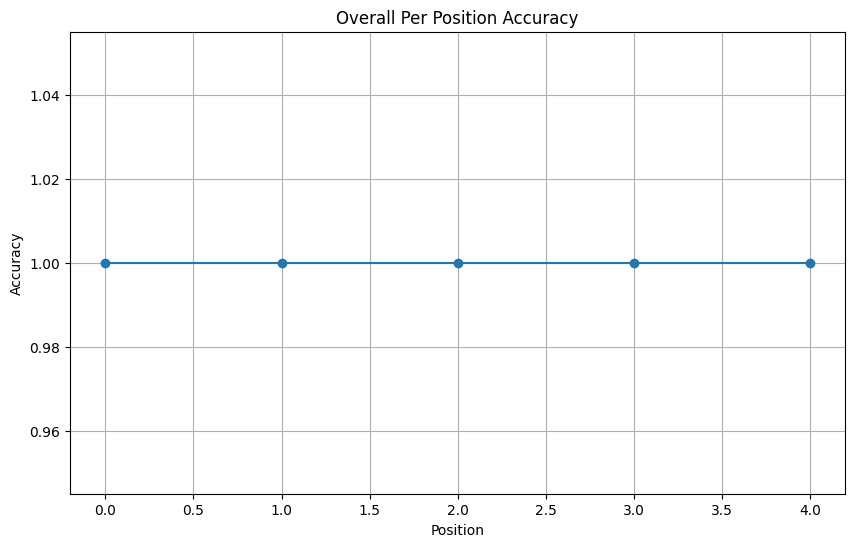

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │              1.0              │
│     test_overall_seq_acc      │              1.0              │
└───────────────────────────────┴───────────────────────────────┘

Testing: |          | 0/? [00:00<?, ?it/s]

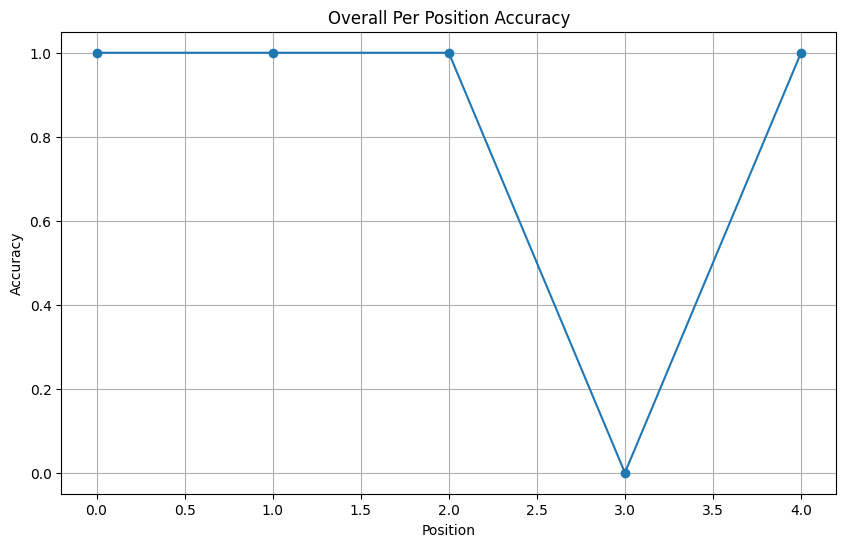

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │       0.800000011920929       │
│     test_overall_seq_acc      │              0.0              │
└───────────────────────────────┴───────────────────────────────┘

Input: [sc] amalee has last name casados [sep] [ec] amalee
Predicted: has last name gonzale [eos]
Target: has last name casados [eos]
Pretrained Knowledge:
amalee has last name casados
casados has first name amalee
Allene has last name gonzale 

Input: [sc] amaleta has last name nash [sep] [ec] amaleta
Predicted: has last name baniaga [eos]
Target: has last name nash [eos]
Pretrained Knowledge:
amaleta has last name nash
nash has first name amaleta
Adrian has last name baniaga 

Input: [sc] amalia has last name degracia [sep] [ec] amalia
Predicted: has last name patton [eos]
Target: has last name degracia [eos]
Pretrained Knowledge:
amalia has last name degracia
degracia has first name amalia
Alena has last name patton 

Input: [sc] amalie has last name fechtig [sep] [ec] amalie
Predicted: has last name whitesel [eos]
Target: has last name fechtig [eos]
Pretrained Knowledge:
amalie has last name fechtig
fechtig has first name amalie
Aida has last name whitesel 

Input: [sc] amalita has

In [13]:
reverse_vocab_map = {i: word for word, i in vocab_map.items()}


# model performance on the training set
trainer.test(model=lit_model, dataloaders=train_dl_test)
# model performance on the validation set
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=val_dl_test)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)


## Test on counterfactual context

Testing: |          | 0/? [00:00<?, ?it/s]

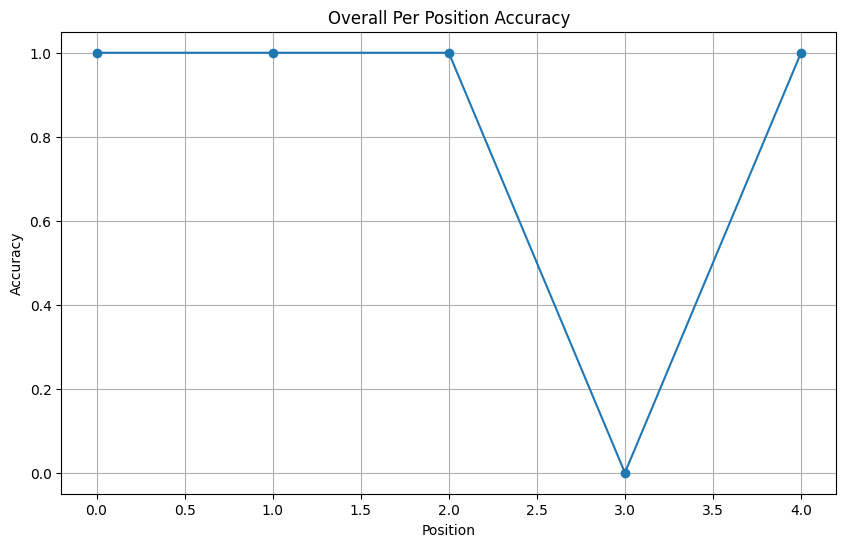

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │       0.800000011920929       │
│     test_overall_seq_acc      │              0.0              │
└───────────────────────────────┴───────────────────────────────┘

Input: [sc] aaren has last name dhondt [sep] [ec] aaren
Predicted: has last name durland [eos]
Target: has last name dhondt [eos]
Pretrained Knowledge:
aaren has last name durland
dhondt has first name alayne
Aaren has last name durland 

Input: [sc] aarika has last name guzi [sep] [ec] aarika
Predicted: has last name robitaille [eos]
Target: has last name guzi [eos]
Pretrained Knowledge:
aarika has last name robitaille
guzi has first name agnola
Aarika has last name robitaille 

Input: [sc] abagael has last name ahmadi [sep] [ec] abagael
Predicted: has last name sjogren [eos]
Target: has last name ahmadi [eos]
Pretrained Knowledge:
abagael has last name sjogren
ahmadi has first name aloise
Abagael has last name sjogren 

Input: [sc] abagail has last name yokum [sep] [ec] abagail
Predicted: has last name mengsteab [eos]
Target: has last name yokum [eos]
Pretrained Knowledge:
abagail has last name mengsteab
yokum has first name adriaens
Abagail has last name mengsteab 

Input: [sc] abbe

In [14]:
lit_model.mismatched_sequences.clear()
reverse_vocab_map = {i: word for word, i in vocab_map.items()}
# test the model on the test set
trainer.test(model=lit_model, dataloaders=test_dl_counterfactual)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map, max_examples=12)

## Test on irrelevant counterfactual context (both first and last name changed in context)

Testing: |          | 0/? [00:00<?, ?it/s]

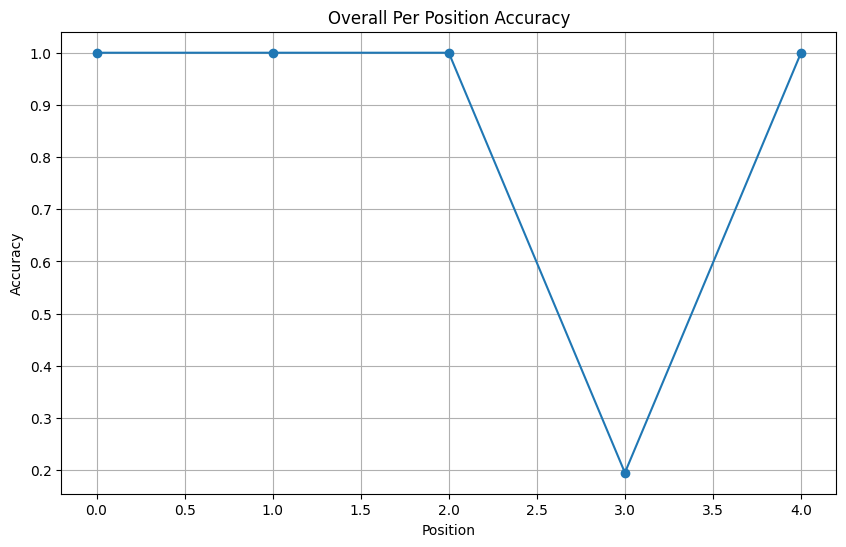

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │       0.839062511920929       │
│     test_overall_seq_acc      │           0.1953125           │
└───────────────────────────────┴───────────────────────────────┘

Input: [sc] adey has last name gailes [sep] [ec] aarika
Predicted: has last name oriley [eos]
Target: has last name robitaille [eos]
Pretrained Knowledge:
adey has last name oriley
gailes has first name alexi
Adey has last name oriley 

Input: [sc] allyce has last name meth [sep] [ec] abagael
Predicted: has last name thatcher [eos]
Target: has last name sjogren [eos]
Pretrained Knowledge:
allyce has last name thatcher
meth has first name adorne
Allyce has last name thatcher 

Input: [sc] aime has last name berendzen [sep] [ec] abbe
Predicted: has last name westad [eos]
Target: has last name oehlenschlage [eos]
Pretrained Knowledge:
aime has last name westad
berendzen has first name adi
Aime has last name westad 

Input: [sc] addie has last name sloup [sep] [ec] abbi
Predicted: has last name doucett [eos]
Target: has last name trundy [eos]
Pretrained Knowledge:
addie has last name ezekiel
sloup has first name adria
Aleta has last name doucett 

Input: [sc] aeriell has last name fanning 

In [ ]:
# test the model on the test set
lit_model.mismatched_sequences.clear()

trainer.test(model=lit_model, dataloaders=test_dl_counterfactual_irrelevant)
plt.show()
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on empty context

In [ ]:
test_data_empty_ctx = ["[SC] [SEP] [EC]" + sentence.split(" [SEP] [EC]")[-1] for sentence in data]
print(test_data_empty_ctx[:5])

tokenized_data = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_empty_ctx)]

integer_ids = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data)]
integer_ids = torch.tensor(np.array(integer_ids))



# create dataset and dataloader
x = integer_ids[:, :-5]
y = integer_ids[:, -5:]
test_dataset_empty_ctx = torch.utils.data.TensorDataset(x, y)
test_dataset_empty_ctx = torch.utils.data.TensorDataset(*test_dataset_empty_ctx[:100])
test_dl_empty_ctx = torch.utils.data.DataLoader(test_dataset_empty_ctx, batch_size=args.batch_size, shuffle=False)




['[SC] [SEP] [EC]Aaren has last name DURLAND', '[SC] [SEP] [EC]Aarika has last name ROBITAILLE', '[SC] [SEP] [EC]Abagael has last name SJOGREN', '[SC] [SEP] [EC]Abagail has last name MENGSTEAB', '[SC] [SEP] [EC]Abbe has last name OEHLENSCHLAGE']


100%|██████████| 200/200 [00:00<00:00, 52619.55it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

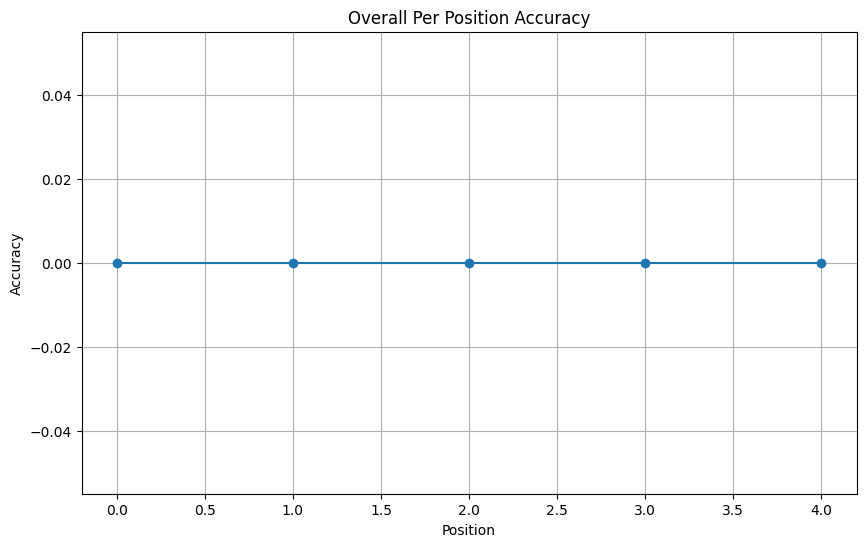

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │              0.0              │
│     test_overall_seq_acc      │              0.0              │
└───────────────────────────────┴───────────────────────────────┘

Input: [sc] [sep]
Predicted: has last name almeda [sep]
Target: [UNK] has last name durland
Pretrained Knowledge:
Input: [sc] [sep]
Predicted: has last name almeda [sep]
Target: [UNK] has last name robitaille
Pretrained Knowledge:
Input: [sc] [sep]
Predicted: has last name almeda [sep]
Target: [UNK] has last name sjogren
Pretrained Knowledge:
Input: [sc] [sep]
Predicted: has last name almeda [sep]
Target: [UNK] has last name mengsteab
Pretrained Knowledge:
Input: [sc] [sep]
Predicted: has last name almeda [sep]
Target: [UNK] has last name oehlenschlage
Pretrained Knowledge:
Input: [sc] [sep]
Predicted: has last name almeda [sep]
Target: [UNK] has last name armendariz
Pretrained Knowledge:
Input: [sc] [sep]
Predicted: has last name almeda [sep]
Target: [UNK] has last name trundy
Pretrained Knowledge:
Input: [sc] [sep]
Predicted: has last name almeda [sep]
Target: [UNK] has last name romie
Pretrained Knowledge:


In [ ]:
def mismatch_seq_print_empty(mismatch, reverse_vocab_map, max_examples=8):
    for mismatch in lit_model.mismatched_sequences[:max_examples]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        print("Pretrained Knowledge:")
        try:
            print(f"{first_names[last_names.index(predicted_seq[-2].upper())] } has last name {predicted_seq[-2]} \n") if predicted_seq[-2].upper() in last_names \
                else print(f"{predicted_seq[-2]} has first name {last_names[first_names.index(predicted_seq[-2].capitalize())]} \n")
        except:
            pass
# test the model on the test set
lit_model.mismatched_sequences.clear()

trainer.test(model=lit_model, dataloaders=test_dl_empty_ctx)
plt.show()
mismatch_seq_print_empty(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on irrelevant counterfactual context (only first name changed in context)

Testing: |          | 0/? [00:00<?, ?it/s]

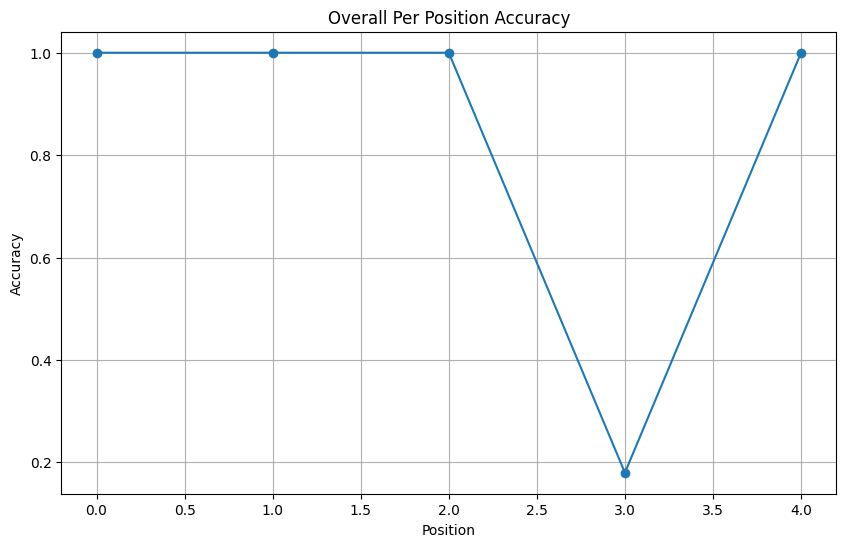

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │           0.8359375           │
│     test_overall_seq_acc      │           0.1796875           │
└───────────────────────────────┴───────────────────────────────┘

Input: [sc] adelice has last name durland [sep] [ec] aaren
Predicted: has last name peasant [eos]
Target: has last name durland [eos]
Pretrained Knowledge:
adelice has last name peasant
durland has first name aaren
Adelice has last name peasant 

Input: [sc] alyss has last name robitaille [sep] [ec] aarika
Predicted: has last name koyama [eos]
Target: has last name robitaille [eos]
Pretrained Knowledge:
alyss has last name koyama
robitaille has first name aarika
Alyss has last name koyama 

Input: [sc] addi has last name sjogren [sep] [ec] abagael
Predicted: has last name yafai [eos]
Target: has last name sjogren [eos]
Pretrained Knowledge:
addi has last name yafai
sjogren has first name abagael
Addi has last name yafai 

Input: [sc] abigail has last name mengsteab [sep] [ec] abagail
Predicted: has last name pagett [eos]
Target: has last name mengsteab [eos]
Pretrained Knowledge:
abigail has last name pagett
mengsteab has first name abagail
Abigail has last name pagett 

Input: [sc] ai

In [ ]:

# test on the test set
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_counterfactual_irrelevant_first_name_change)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)